# Analyze $d_0*\mathrm{charge}$ distributions.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/Users/Jake/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

# Neat tricks.
from itertools import chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Local imports. 
from PyUtils.Utils_Files import makeDirs, make_str_title_friendly, check_overwrite
from PyUtils.Utils_Plotting import (change_cmap_bkg_to_white, save_plots_to_outpath, make_1D_dist, get_stats_1Dhist, 
                                    get_stats_2Dhist, hist_y_label, make_2by2_subplots_for_ratioplots,
                                    add_underoverflow_entries, make_stats_legend_for_1dhist, make_stats_legend_for_2dhist, 
                                    make_stats_legend_for_gaus_fit)
from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta, calc_dR, calc_dphi
from PyUtils.Utils_StatsAndFits import gaussian, fit_with_gaussian, iterative_fit_gaus
from PyUtils.Utils_Collection_Helpers import weave_lists
from d0_Utils.d0_cls import KinematicBin
from d0_Utils.d0_fns import (make_binning_array, shift_binning_array, get_subset_mask, make_kinem_subplot, calc_x_err_bins, combine_cut_list)
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

plt.rcParams.update({'figure.max_open_warning': 10})    # Related to saving memory and opening plots.

# pd.options.display.max_columns = 23
pd.options.display.max_columns = None

plt.style.use('cmsstyle_plot')
# plt.style.use("grid_multiple_plots")

In [2]:
%%time
infile_path_MC_2016 = '/Users/Jake/Desktop/MC_2016.h5'
infile_path_MC_2017 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2017.feather'
infile_path_MC_2018 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2018.feather'

# df_MC_2016 = pd.read_feather(infile_path_MC_2016)
# df_MC_2017 = pd.read_feather(infile_path_MC_2017)
# df_MC_2018 = pd.read_feather(infile_path_MC_2018)

df_MC_2016 = pd.read_hdf(infile_path_MC_2016)
# df_MC_2017 = pd.read_hdf(infile_path_MC_2017)
# df_MC_2018 = pd.read_hdf(infile_path_MC_2018)

CPU times: user 225 ms, sys: 6.76 s, total: 6.99 s
Wall time: 17.4 s


In [3]:
class KinBinOrganizer():
    """
    Creates and organizes KinematicBin objects which all have exactly the same cuts, except for d0 cuts. 
    """
    def __init__(self, 
                 df, 
                 n_evts_scan=1000, 
                 massZ_cut_ls=[60,120],
                 eta_cut_ls=[0.0, 0.3], 
                 pT_cut_ls=[20, 60], 
                 d0_type='BS', 
                 dR_cut=0.05, 
                 use_ptotal_instead=False, 
                 verbose=True):
        """
        These cuts will apply to all KinematicBin objects within this KinBinOrganizer container.
        """
        self.df = df 
        self.n_evts_scan = n_evts_scan
        self.massZ_cut_ls = massZ_cut_ls
        self.eta_cut_ls = eta_cut_ls
        self.pT_cut_ls = pT_cut_ls
        self.d0_type = d0_type
        self.dR_cut = dR_cut
        self.use_ptotal_instead = use_ptotal_instead
        self.verbose = verbose
        
    def make_kbin_ls_over_d0_range(self, d0_bin_limits):
        """
        Make a list of KinematicBin objects, all with identical cuts EXCEPT d0q cuts. 
        """
        d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
        
        if d0_bin_width < 0.0005:
            err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
            raise ValueError(err_msg)    
            
        self.d0_bin_arr = d0_bin_arr
        self.d0_bin_arr_shifted = shift_binning_array(self.d0_bin_arr)
        
        kbin_ls = []
        for elem in range(len(d0_bin_arr)-1):
            # Make a kbin for each d0 bin.
            d0_this = d0_bin_arr[elem]
            d0_next = d0_bin_arr[elem+1]

            kb = KinematicBin(df_original=self.df, 
                              n_evts=self.n_evts_scan, 
                              massZ_cut_ls=self.massZ_cut_ls,
                              eta_cut_ls=self.eta_cut_ls, 
                              pT_cut_ls=self.pT_cut_ls, 
                              d0q_cut_ls=[d0_this, d0_next],
                              d0_type=self.d0_type,
                              dR_cut=self.dR_cut,
                              use_ptotal_instead=self.use_ptotal_instead, 
                              verbose=self.verbose)
            kbin_ls.append(kb)
            
        self.kbin_ls = kbin_ls

    def plot_dpToverpT_for_kbin_ls(self, kinem="delta_pToverpT1", lep_selection_type='independent', 
                                   x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=-1, ax=None, y_max=-1, log_scale=False, iter_gaus=(False, 3),
                                   make_pdf=False, pdf_obj=None ):
        """
        The main purpose of making these plots is to fill the stats_dict for each kbin.
        
        Parameters
        ----------
        make_pdf : 
        
        """
        for kb in self.kbin_ls:
            kb.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 3))
#             kb.plot_1D_kinematics(kinem=kinem, lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 3))            
            if (make_pdf):
                pdf_obj.savefig()
            plt.close()
        # All kbins have filled their stats_dict.
            
    def get_dpToverpT_iter_gaus_fit_means(self):
        """"""
        # Get graph values.
        self.hist_mean_ls     = []
        self.hist_mean_err_ls = []
        self.fit_mean_ls      = []
        self.fit_mean_err_ls  = []
        
        for kb in self.kbin_ls:
            self.hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
            self.hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
            self.fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
            self.fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])
            
            
class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None, count=1):
        """
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        color : int
            A key to a dictionary of colors. 
            Values are color strings, like: 'black', 'red', etc. 
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ms=4  # marker size
        ecolor=color_dict[count]
        mec=color_dict[count]  # Marker edge color.
        mfc=color_dict[count]  # Marker face color.
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
            unit_x = label_LaTeX_dict[kinem_x]["units"]
            if len(unit_x) > 0:
                x_label += " [{}]".format(unit_x)
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        title = label_LaTeX_dict[binning_type + "1"]["independent_label"] + " Binning"
#         if binning_type == "eta":
#             title = r"$\left| $" + title + r"$\right| $"
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='s', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, mec=mec, capsize=cs, mew=mew, mfc=mfc, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = "Selections:\n" + cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        
        if count == 1:
            ax.text(0.025, 0.915, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

# Make $dp_T/p_T$ Gaus core mean vs. $d_0*q$ plots:

- [X] Get Graph() class to draw one graph. 
- [ ] Get Graph() class to draw TWO graphs. 

In [ ]:
kbin = KinematicBin(df_MC_2016, 
                    n_evts=10000, 
                    massZ_cut_ls=[60,120],
                    eta_cut_ls=[0.0, 0.3], 
                    pT_cut_ls=[40, 50], 
                    d0q_cut_ls=[-0.005, 0.005],
                    d0_type='BS',
                    dR_cut=0.02,
                    use_ptotal_instead=False, 
                    verbose=True)

In [4]:
%%time
%config InlineBackend.figure_format = 'retina'
# f, ax = plt.subplots(figsize=(12.8,9.6))

n_evts_scan = 100000
n_evts_keep = -1

d0_bin_limits = [-0.003, 0.003, 0.001]
massZ_cut_ls=[60,120]
eta_cut_ls=[
#     [0.0, 0.4],
#     [0.4, 0.8],
#     [0.8, 1.4],
    [1.4, 2.0],
    [2.0, 2.4],
]
pT_cut_ls=[20,30]
# [5, 7],
# [7, 10],
# [10, 15],
# [15, 20],
# [20, 25],
# [25, 30],
# [30, 35],
# [35, 40],
# [40, 45],
# [45, 50],
# [50, 55],
# [55, 60],
# [60, 65],
# [65, 70],
# [70, 75],
# [75, 80],
# [80, 90],
# [90, 100],
# ]

d0_type='BS'
dR_cut=0.05
use_ptotal_instead=False
fit_iters = 3

outpath = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/20200427/run_over_d0_bins_test_11_pTbinning.pdf"
verbose = False

#--- Automatons ---#
dir_ = os.path.dirname(outpath)
makeDirs(dir_)    

org_kbin_ls = []
with PdfPages(outpath) as pdf:
    for eta_reg_ls in eta_cut_ls: 
        org_kbin = KinBinOrganizer(df_MC_2016, n_evts_scan, massZ_cut_ls, eta_reg_ls, pT_cut_ls, d0_type, dR_cut, use_ptotal_instead, verbose)
        org_kbin.make_kbin_ls_over_d0_range(d0_bin_limits)
        org_kbin.plot_dpToverpT_for_kbin_ls(kinem="delta_pToverpT1", lep_selection_type='independent', 
                                           x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], 
                                           run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, 
                                           iter_gaus=(True, fit_iters),
                                           make_pdf=False,
                                           pdf_obj=pdf    # Must pass in pdf object here, if make_pdf=True!
                                           )  
        org_kbin.get_dpToverpT_iter_gaus_fit_means()

        org_kbin_ls.append(org_kbin)
        plt.close("all")
    # Done looping over all eta regions.
    
    graph_ls = []
#     f, ax = plt.subplots(figsize=(12.8, 9.6))
    f, ax = plt.subplots()
    for count,org_kb in enumerate(org_kbin_ls, 1):
        graph = GraphLine(org_kb.d0_bin_arr_shifted, org_kb.fit_mean_ls, org_kb.fit_mean_err_ls)
        graph.draw_graph("d0BSq1", "delta_pToverpT1", binning_type="eta", kbin_example=org_kb.kbin_ls[0], ax=ax, count=count+1)
        
        graph_ls.append(graph)
    # Done looping over KinBinOrganizers.
    plt.tight_layout()
    pdf.savefig()
    plt.close("all")

Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
Performing 3 iterative Gaussian fits
CPU times: user 29.7 s, sys: 17.7 s, total: 47.4 s
Wall time: 25.9 s


In [ ]:

                      

    
    pdf_name  = f"{year}_{sample}_{bspv}__"
    title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
    # Example of Python magic: auto-concatenation of strings.
    pdf_name += (f"{title_str_pT_min}_pT_{pT_max}"
                 f"__{eta_min}_eta_{eta_max}"
                 f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}"
                 f"__wrt_{wrt}")
    pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
    
    outfile = os.path.join(outfile_path, pdf_name)
    if not os.path.exists(outfile_path):
        os.makedirs(outfile_path)
    if os.path.exists(outfile) and not (overwrite):
        print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
        return
        
    status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
    print(status)

            # Store info of this plot in a HistInfo object. 
            this_hist = HistInfo()            
            this_hist.year = year
            this_hist.sample = sample
            this_hist.bspv = bspv
            this_hist.d0_bin_window = [this_d0_bin, next_d0_bin]
            this_hist.x_axis_bounds_list = deltapT_range_ls[0:2] # 2-element list
            this_hist.eta_range = eta_cut_ls
            this_hist.pT_range = pT_cut_ls
            this_hist.massZ_cut = massZ_min
            this_hist.n_entries = n_entries
            this_hist.hist_mean = mean
            this_hist.hist_mean_err = mean_err
            this_hist.hist_stdev = stdev  # Spread of the data.
            this_hist.hist_stdev_err = stdev_err
            
            graph_info_ls.append(this_hist)
            
        return graph_info_ls


In [ ]:
kb_test = org_kbin.kbin_ls[0]

In [ ]:
org_kbin.d0_bin_arr_shifted

# Grids of 2D plots.

#### FIXME: 
- [ ] Use np.arrays to contain kbins for easy reshaping?
- [ ] Eventually merge into make_grid_of_2D_plots_FIXME.py

In [ ]:
%%time

n_evts = 10000

eta_bin_BARREL  = [0.0, 0.3]
eta_bin_OVERLAP = [0.8, 1.1]
eta_bin_ENDCAP  = [2.1, 2.4]


pT_bin_LOW1 = [5, 7]
pT_bin_LOW2 = [7, 10]
pT_bin_LOW3 = [10, 15]
pT_bin_LOW4 = [15, 20]
pT_bin_LOW5 = [20, 25]
pT_bin_LOW6 = [25, 30]

pT_bin_MED1 = [30, 35]
pT_bin_MED2 = [35, 40]
pT_bin_MED3 = [40, 45]
pT_bin_MED4 = [45, 50]
pT_bin_MED5 = [50, 55]
pT_bin_MED6 = [55, 60]

pT_bin_HIGH1 = [60, 65]
pT_bin_HIGH2 = [65, 70]
pT_bin_HIGH3 = [70, 75]
pT_bin_HIGH4 = [75, 80]
pT_bin_HIGH5 = [80, 90]
pT_bin_HIGH6 = [90, 100]

#--------------#
#--- Barrel ---#
#--------------#
# Low pT.
kbin_eta_BARREL_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# Med pT.
kbin_eta_BARREL_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
kbin_eta_BARREL_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_BARREL_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_BARREL_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_BARREL, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)


# #---------------#
# #--- Overlap ---#
# #---------------#
# # Low pT.
# kbin_eta_OVERLAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_OVERLAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_OVERLAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_OVERLAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_OVERLAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

# #---------------#
# #--- Endcap ---#
# #---------------#
# # Low pT.
# kbin_eta_ENDCAP_pT_bin_LOW1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_LOW6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_LOW6, dR_cut=0.02)

# # Med pT.
# kbin_eta_ENDCAP_pT_bin_MED1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_MED6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_MED6, dR_cut=0.02)

# # High pT.
# kbin_eta_ENDCAP_pT_bin_HIGH1 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH1, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH2 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH2, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH3 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH3, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH4 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH4, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH5 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH5, dR_cut=0.02)
# kbin_eta_ENDCAP_pT_bin_HIGH6 = KinemBinnedEtaPt(df_MC_2016, n_evts=n_evts, eta_cut_ls=eta_bin_ENDCAP, pT_cut_ls=pT_bin_HIGH6, dR_cut=0.02)

In [18]:
dir(org_kbin)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'd0_bin_arr',
 'd0_bin_arr_shifted',
 'd0_type',
 'dR_cut',
 'df',
 'eta_cut_ls',
 'fit_mean_err_ls',
 'fit_mean_ls',
 'get_dpToverpT_iter_gaus_fit_means',
 'hist_mean_err_ls',
 'hist_mean_ls',
 'kbin_ls',
 'make_kbin_ls_over_d0_range',
 'massZ_cut_ls',
 'n_evts_scan',
 'pT_cut_ls',
 'plot_dpToverpT_for_kbin_ls',
 'use_ptotal_instead',
 'verbose']

In [21]:
for key,val in org_kbin.__dict__.items():
    print("key is:", key, "   value is:", val)

key is: df    value is:                massZ  massZErr   massZ_vtx  massZ_vtx_FSR  massErrZ_vtx  \
0         103.728906  1.111374  103.696281     103.696278      1.111702   
1          91.831300  1.099784   91.741104      91.741107      1.099111   
2          93.614336  1.193765   93.504822      93.504828      1.193027   
3          95.046227  0.797954   94.781395      94.781394      0.797963   
4          90.022895  0.745634   89.893692      89.893697      0.746406   
...              ...       ...         ...            ...           ...   
15725105   88.555064  1.416749   88.369995      88.369993      1.419809   
15725106   90.149912  0.848034   90.303856      90.303854      0.846562   
15725107   89.563863  0.586469   89.604568      89.604574      0.586570   
15725108   74.360814  0.641717   74.286110      74.286112      0.643363   
15725109  101.081437  0.992111  101.028442     101.028439      0.990909   

          massErrZ_vtx_FSR  massZ_vtxChi2  massZ_vtx_BS  massZ_vtx_BS_FSR  

In [ ]:
import matplotlib.pyplot as plt
from d0_Utils.d0_fns import calc_x_err_bins
from d0_Utils.d0_dicts import color_dict, label_LaTeX_dict

class GraphLine():
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    def __init__(self, x_vals, y_vals, y_err_vals=np.zeros(0)):
        self.x_vals = x_vals
        self.y_vals = y_vals
#         self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
    def draw_graph(self, kinem_x, kinem_y, x_label="", y_label="", binning_type="", kbin_example=None, ax=None):
        """
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        """
        if binning_type not in ["eta", "pT"]:
            raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
#         #--- Check that things make sense: ---#
#         # Example: If binning in eta, make sure each HistInfo object has identical pT_cuts as every other.
#         wrong_eta_binning = (binning_type in 'eta') and len(set([(hist.pT_range[0], hist.pT_range[1]) for hist in entire_HistInfo_list])) != 1
#         # Do same thing for binning in pT.
#         wrong_pT_binning = (binning_type in 'pT') and len(set([(hist.eta_range[0], hist.eta_range[1]) for hist in entire_HistInfo_list])) != 1
#         if (wrong_eta_binning or wrong_pT_binning):
#             err_msg = f"\n\nBinning type ({binning_type}) specified, "
#             err_msg += f"but not all graphs share same {binning_type}_range. Stopping now."
#             raise RuntimeError(err_msg)
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ecolor='k'
        ms=4  # marker size
        mec='k'  # marker edge color
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = label_LaTeX_dict[kinem_x]["independent_label"]
        if len(y_label) == 0:
            y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
            y_label += " (iterated Gaus fit mean)"
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
        low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        label_text = kbin_example.cut_dict[binning_type]
        ax.errorbar(self.x_vals, self.y_vals, xerr=[low_x_err, high_x_err], yerr=self.y_err_vals, fmt='.', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
        tmp_dict = kbin_example.cut_dict.copy()
        for key in list(kbin_example.cut_dict.keys()):
            if (binning_type in key) or ("d0" in key):
                del tmp_dict[key]
                    
        sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
        cut_str = combine_cut_list(sorted_cut_ls)
        textbox_text = cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        ax.text(0.025, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
    def do_linear_fit(self, ax=None):
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8,9.6)) 
        
        # Do fit. 
        # Draw fit on axes.
        # return optimized parameters
        self.popt_linear = None

In [1]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

In [ ]:
rescue_code()

In [ ]:
KinBin

In [ ]:
n_evts = 1000

# dataframe = pd.read_hdf('/Users/Jake/Desktop/MC_2016.h5')


massZ_cut_ls = [60,120]
d0q_cut_ls = [-0.01, 0.01]
d0_type = "BS"
dR_cut = 0.02
use_ptotal_instead = False
verbose = False

eta_regions = [
    [0.0, 0.3],
    [0.8, 1.1],
#     [2.1, 2.4]
]

# You should make there's always 18 different regions.
pT_regions = [
    [5, 7]  ,
    [7, 10] ,
    [10, 15],
    [15, 20],
    [20, 25],
#     [25, 30],
#     [30, 35],
#     [35, 40],
#     [40, 45],
#     [45, 50],
#     [50, 55],
#     [55, 60],
#     [60, 65],
#     [65, 70],
#     [70, 75],
#     [75, 80],
#     [80, 90],
#     [90, 100]
]

all_kbin_ls = []
for eta_reg in eta_regions:
    for pT_reg in pT_regions:
        all_kbin_ls.append( KinematicBin(df_MC_2016, n_evts, massZ_cut_ls, eta_reg, pT_reg, d0q_cut_ls, 
                                         d0_type, dR_cut, use_ptotal_instead, verbose) 
                          )

In [ ]:
kb1 = all_kbin_ls[0]
kb2 = all_kbin_ls[1]
kb3 = all_kbin_ls[2]

# First edition $dp_T/p_T^2$ vs. $d_0*q$ plotter

In [ ]:
def make_graph(*graph_tuple, binning_type='eta', verbose=False, save_plots=True, outpath='/Users/Jake/Desktop/'):
    """
    Make one deltapT vs. d0*charge plot, with as many graphs displayed as len(graph_tuple).
    graph_tuple contains many lists (graph_lsX) of histograms (HistInfo).
    
    graph_tuple = (
        graph_ls1,  # Each hist in this graph_ls all have identical cuts, but are made over different d0 bins.
        graph_ls2,  # This graph_ls2 may have slightly different cuts than graph_ls1.
        ...,
    )
    
    #--- Example ---#
    graph_ls1 = [HistInfo1, HistInfo2, ...]  # This list will generate 1 deltapT_vs_d0charge graph. 
    graph_ls2 = [HistInfo1, HistInfo2, ...]  # This list will generate another graph, but may have different cuts. 

    If binning_type is 'eta', then each graph_ls in graph_tuple should have the same pT cuts.
        This way, we can view different eta ranges while making sure pT cuts are all the same. 
    If binning_type is 'pT', then each graph_ls in graph_tuple should have the same eta cuts. 
    
    Returns
    -------
    graph_ls contains all the correct graph info to make a plot. 
    """    

        
    text_size_legend = 6
    text_size_ax_labels = 12
    text_size_tick_labels = 8
    text_size_title = 12


    # If binning in eta, then each graph should the same pT cuts. 
    if binning_type in 'eta':
        title_str += f'{example_graph.pT_range[0]}<' + r'$p_T$' + f'<{example_graph.pT_range[1]} GeV'
    elif binning_type in 'pT':
        title_str += f'{example_graph.eta_range[0]}<' + r'$\left| \eta \right|$' + f'<{example_graph.eta_range[1]}'
    ax.set_title(title_str)

    x_min = min([gr.d0_bin_window[0] for gr in example_graph_ls])
    x_max = max([gr.d0_bin_window[1] for gr in example_graph_ls])
    bin_edge_left = example_graph.d0_bin_window[0]
    bin_edge_right = example_graph.d0_bin_window[1]
    x_bin_width = abs(bin_edge_right - bin_edge_left)

    # ax.set_xlim([x_min*x_axis_scale, x_max*x_axis_scale])
    ax.set_xlim([-0.012, 0.012])
    ax.set_ylim([-0.005, 0.005])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    
    # Gridlines.
    ax.grid(which='major',color='k', ls=':')

    x_bin_arr = np.arange(x_min, x_max+0.5*x_bin_width, x_bin_width)  # Includes all bin edges: very first to very last.
    x_n_bins = calc_num_bins(x_min, x_max, x_bin_width)

    # Calculate %diff for ratio plot.
    # acc_ZD_arr = np.array(acc_ZD, dtype=float)
    # acc_ALP_arr = np.array(acc_ALP, dtype=float)
    # acc_perc_diff_arr = (acc_ALP_arr - acc_ZD_arr) / acc_ZD_arr

    # Calculate errors on %diff.
    # acc_perc_diff_err_arr = getUncertOfFractionBinomial(acc_ALP_arr, acc_ZD_arr)

    # Plot the data.
    for count, gr_ls in enumerate(graph_tuple, 1):
        example_gr = gr_ls[0]
        y_vals = [gr.hist_mean for gr in gr_ls]
        y_vals_err = [gr.hist_mean_err for gr in gr_ls]
        if (verbose): 
            print(f'y_vals for graph_ls {count}:\n{y_vals}\n')

            
            
    
        plotname  = (f'deltapT_vs_d0{example_graph.bspv}timescharge_{example_graph.sample}{example_graph.year}_'
                     f'{binning_type}binning__')
        if binning_type in 'pT':
            plotname += f'{example_graph.eta_range[0]}_eta_{example_graph.eta_range[1]}'
        elif binning_type in 'eta':
            plotname += f'{example_graph.pT_range[0]}_pT_{example_graph.pT_range[1]}'
        plotname = make_str_title_friendly(plotname)
        
        fullpath = os.path.join(outpath, plotname)
        if not os.path.exists(outpath):
            os.makedirs(outpath)
        plt.savefig(fullpath + '.pdf')
        plt.savefig(fullpath + '.png')
        print("Plot saved at:\n", fullpath)
    

# def make_kinem_comparison_plot(df, year, sample, 
# 
#     
#     pdf_name  = f"{year}_{sample}_"
#     title_str_pT_min = f"0{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
#     # Example of Python magic: auto-concatenation of strings.
#     pdf_name += (f"{kinem_gen}_vs_{kinem_rec}__{bspv}"
#                  f"__{title_str_pT_min}_pT_{pT_max}"
#                  f"__{eta_min_abs}_abs_eta_{eta_max_abs}"
#                  f"__{d0_min:.3f}_to_{d0_max:.3f}_increm_{d0_bin_width:.3f}")
#                 #  f"__wrt_{wrt}")
#     pdf_name = make_str_title_friendly(pdf_name) + ".pdf"
#     
#     outfile = os.path.join(outfile_path, pdf_name)
#     if not os.path.exists(outfile_path):
#         os.makedirs(outfile_path)
#     if os.path.exists(outfile) and not (overwrite):
#         print(f"Skipping {outfile} since it already exists.\nTo write over the file then set overwrite=True.\n")
#         return
#         
#     status = f"Running over: {year} {sample} {bspv}, pT_range={pT_cut_ls}, eta_range={eta_cut_ls}, wrt {wrt}"
#     print(status)
# 
# 
#         for k in range(len(d0_bin_arr)-1):
#             this_d0_bin = d0_bin_arr[k]
#             next_d0_bin = d0_bin_arr[k+1]
#             if bspv in 'BS':
#                 mask_d0BSxcharge = (this_d0_bin < d0BSxcharge_ser) & (d0BSxcharge_ser < next_d0_bin)
#                 # mask_d0BS2xcharge = (this_d0_bin < d0BS2xcharge_ser) & (d0BS2xcharge_ser < next_d0_bin)
#             elif bspv in 'PV':
#                 mask_d0PVxcharge = (this_d0_bin < d0PVxcharge_ser) & (d0PVxcharge_ser < next_d0_bin)
#                 # mask_d0PV2xcharge = (this_d0_bin < d0PV2xcharge_ser) & (d0PV2xcharge_ser < next_d0_bin)
# 
#                 
#  
#             # Store info of this plot in HistInfo objects. 
#             hist_gen = HistInfo()
#             hist_rec = HistInfo()            
#             hist_gen.year = year
#             hist_rec.year = year
#             hist_gen.sample = sample 
#             hist_rec.sample = sample
#             hist_gen.bspv = bspv 
#             hist_rec.bspv = bspv
#             hist_gen.d0_bin_window = [this_d0_bin, next_d0_bin] 
#             hist_rec.d0_bin_window = [this_d0_bin, next_d0_bin]
#             hist_gen.x_axis_bounds_list = x_range_ls[0:2] # 2-element list 
#             hist_rec.x_axis_bounds_list = x_range_ls[0:2] # 2-element list
#             hist_gen.eta_range = eta_cut_ls 
#             hist_rec.eta_range = eta_cut_ls
#             hist_gen.pT_range = pT_cut_ls
#             hist_rec.pT_range = pT_cut_ls
#             hist_gen.massZ_cut = massZ_min
#             hist_rec.massZ_cut = massZ_min
#             hist_gen.n_entries = n_entries_gen
#             hist_rec.n_entries = n_entries_rec
#             hist_gen.hist_mean = mean_gen
#             hist_rec.hist_mean = mean_rec
#             hist_gen.hist_mean_err = mean_err_gen
#             hist_rec.hist_mean_err = mean_err_rec
#             hist_gen.hist_stdev = stdev_gen
#             hist_rec.hist_stdev = stdev_rec  # Spread of the data.
#             hist_gen.hist_stdev_err = stdev_err_gen
#             hist_rec.hist_stdev_err = stdev_err_rec
#             
#             graph_info_gen_ls.append(hist_gen)
#             graph_info_rec_ls.append(hist_rec)
 

In [ ]:
%config InlineBackend.figure_format ='retina'

fig = plt.figure(figsize=(25.6,19.2))
ax = plt.subplot(221)
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 3))
ax = plt.subplot(222)
kbin.plot_1D_kinematics(kinem="delta_pToverRecpT1", lep_selection_type='independent', x_limits=[-0.5, 0.5], bin_limits=[-0.5, 0.5, 0.004], run_over_only_n_evts=-1, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))
ax = plt.subplot(223)
kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(True, 4))
ax = plt.subplot(224)
kbin.plot_1D_kinematics(kinem="d0BSq2", lep_selection_type='independent', x_limits=[-0.05, 0.05], bin_limits=[-0.02, 0.02, 0.0004], run_over_only_n_evts=n_evts_keep, ax=ax, y_max=-1, log_scale=False, iter_gaus=(False, 3))

# Kinematics subplots.

In [ ]:
# kbin.plot_1D_kinematics(kinem="d0BSq1", lep_selection_type='independent', x_limits=[-0.02, 0.02], bin_limits=[-0.008, 0.008, 0.0002], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))

In [ ]:
kbin.cut_dict.copy()

In [ ]:
play_dict.items()

In [ ]:
[key for key in play_dict.keys()]

In [ ]:
play_dict = {'a':1, 'b':2, 'c':4}

In [ ]:
graph_test.draw_graph("d0BSq1","delta_pToverpT1",kbin_example=kbin_ls[0])

In [ ]:
kbin.stats_dict

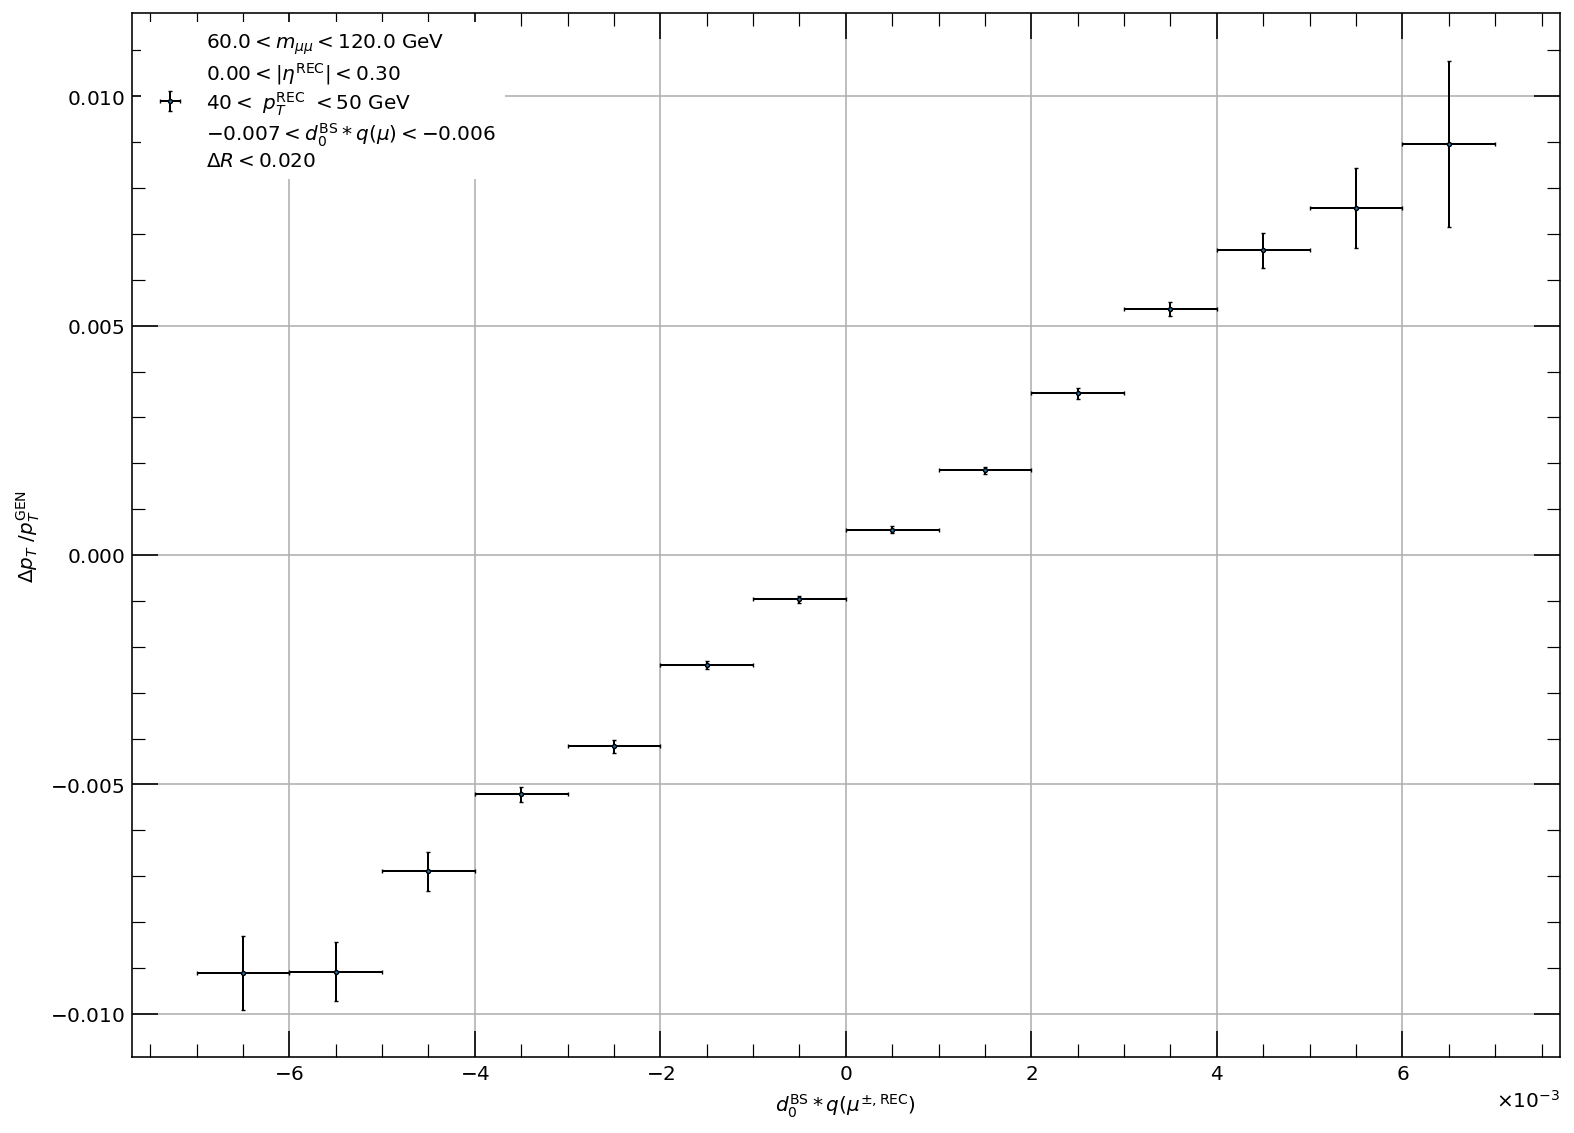

In [55]:
graph_test.draw_graph("d0BSq1","delta_pToverpT1",kbin_example=kbin_ls[0])

In [49]:
np.zeros(0)

array([], dtype=float64)

In [ ]:
# hist_mean = kbin.stats_dict['delta_pToverpT1']['hist_stats'][1]
# hist_mean_err = kbin.stats_dict['delta_pToverpT1']['hist_stats'][2]
# fit_mean = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1]
# fit_mean_err = kbin.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1]

d0_bin_arr, d0_bin_width = make_binning_array(d0_bin_limits)
d0_bin_arr_shifted = shift_binning_array(d0_bin_arr)

if d0_bin_width < 0.0005:
    err_msg = f"WARNING: d0_bin_width ({d0_bin_width}) is too small (d0_bin_width < 0.0005).\nStopping now."
    raise ValueError(err_msg)    

# Make list of kinematic bins.
kbin_ls = []
with PdfPages(outpath) as pdf:
    for elem in range(len(d0_bin_arr)-1):
        # Make a kbin for each d0 bin.
        d0_this = d0_bin_arr[elem]
        d0_next = d0_bin_arr[elem+1]

        kbin = KinematicBin(df_MC_2016, 
                            n_evts=n_evts_scan, 
                            massZ_cut_ls=[60,120],
                            eta_cut_ls=[0.0, 0.3], 
                            pT_cut_ls=[40, 50], 
                            d0q_cut_ls=[d0_this, d0_next],
                            d0_type='BS',
                            dR_cut=0.02,
                            use_ptotal_instead=False, 
                            verbose=True)
        kbin.plot_1D_kinematics(kinem="delta_pToverpT1", lep_selection_type='independent', x_limits=[-0.3, 0.3], bin_limits=[-0.3, 0.3, 0.004], run_over_only_n_evts=n_evts_keep, ax=None, y_max=-1, log_scale=False, iter_gaus=(True, 4))
        kbin_ls.append(kbin)
        
        pdf.savefig()
        plt.close()

# Get graph values.
hist_mean_ls     = []
hist_mean_err_ls = []
fit_mean_ls      = []
fit_mean_err_ls  = []
for kb in kbin_ls:
    hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
    hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
    fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
    fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])

al=1  # alpha=0 is transparent
elw=1  # error bar line width
ecolor='k'
ms=4  # marker size
mec='k'  # marker edge color
cs=1  # cap size
mew=0.7  # marker edge width

low_x_err, high_x_err = calc_x_err_bins(d0_bin_arr_shifted)
    
fig, ax = plt.subplots(figsize=(12.8,9.6))

# legend_text = ""
# ax.text(k, y, "Some words", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#             legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
ax.errorbar(d0_bin_arr_shifted, fit_mean_ls, xerr=[low_x_err, high_x_err], 
            yerr=fit_mean_err_ls, fmt='s', label="some cuts go here?",
        #color=color_dict[count], 
            elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
ax.legend(loc='upper left', framealpha=al)#, fontsize=text_size_legend)

In [30]:
hist_mean_ls     = []
hist_mean_err_ls = []
fit_mean_ls      = []
fit_mean_err_ls  = []
for kb in kbin_ls:
    hist_mean_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][1])
    hist_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['hist_stats'][2])
    fit_mean_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_ls'][-1])
    fit_mean_err_ls.append(kb.stats_dict['delta_pToverpT1']['fit_stats']['mean_err_ls'][-1])

al=1  # alpha=0 is transparent
elw=1  # error bar line width
ecolor='k'
ms=4  # marker size
mec='k'  # marker edge color
cs=1  # cap size
mew=0.7  # marker edge width

low_x_err, high_x_err = calc_x_err_bins(d0_bin_arr_shifted)
    
fig, ax = plt.subplots(figsize=(12.8,9.6))

# legend_text = ""
# ax.text(k, y, "Some words", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#             legend_text = f'{example_gr.pT_range[0]} <' + r' $p_T$ ' + f'< {example_gr.pT_range[1]}'
ax.errorbar(d0_bin_arr_shifted, fit_mean_ls, xerr=[low_x_err, high_x_err], 
            yerr=fit_mean_err_ls, fmt='s', label="some cuts go here?",
        #color=color_dict[count], 
            elinewidth=elw, ms=ms, markeredgecolor=mec, capsize=cs, mew=mew, ecolor=ecolor)
ax.legend(loc='upper left', framealpha=al)#, fontsize=text_size_legend)